In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os
import seaborn as sns
# import tensorflow as tf
from sklearn.model_selection import train_test_split

from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error, precision_score, recall_score, roc_auc_score
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [2]:
df_recipes = pd.read_csv("../data/df_with_diets.csv")
df_reviews = pd.read_csv("../data/reviews.csv")

Later on in our notebook we will fill not rated recipes with 0. In order not to mess up the ratings we will adjust them by moving them from 0-5 to 1-6. So the not rated ones will have the new value 0.

In [3]:
# Change rating in order to make initial given 0 count unlike the 0 given for mising ratings
def update_rating(value, updated):
    if updated:
        return value
    if value == 0:
        return 1, True
    elif value == 1:
        return 2, True
    elif value == 2:
        return 3, True
    elif value == 3:
        return 4, True
    elif value == 4:
        return 5, True
    elif value == 5:
        return 6, True
    else:
        return value, False  

# Creates a new column to check if values are already adjusted
df_reviews['Updated'] = False

# # Apply the function to the entire column "Rating" in the DataFrame "df_reviews"
df_reviews['Rating'], df_reviews['Updated'] = zip(*df_reviews.apply(lambda row: update_rating(row['Rating'], row['Updated']), axis=1))

# Removing the auxiliary column 'Updated
del df_reviews['Updated']

In [4]:
df_recipes.head()

,RecipeId,Name,AuthorId,AuthorName,CookTime,PrepTime,TotalTime,DatePublished,Description,Images,...,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions,search_terms,vegan,vegetarian,lactosefree,glutenfree
0,38,Low-Fat Berry Blue Frozen Dessert,1533,Dancer,PT24H,PT45M,PT24H45M,1999-08-09T21:46:00Z,Make and share this Low-Fat Berry Blue Frozen ...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,30.2,3.2,4.0,NaN,"c(""Toss 2 cups berries with sugar."", ""Let stan...","{'low-calorie', 'low-sodium', 'dessert', 'heal...",0,0,0,1
1,39,Biryani,1567,elly9812,PT25M,PT4H,PT4H25M,1999-08-29T13:12:00Z,Make and share this Biryani recipe from Food.com.,"c(""https://img.sndimg.com/food/image/upload/w_...",...,20.4,63.4,6.0,NaN,"c(""Soak saffron in warm milk for 5 minutes and...","{'indian', 'dinner', 'low-sodium'}",0,0,0,0
2,40,Best Lemonade,1566,Stephen Little,PT5M,PT30M,PT35M,1999-09-05T19:52:00Z,This is from one of my first Good House Keepi...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,77.2,0.3,4.0,NaN,"c(""Into a 1 quart Jar with tight fitting lid, ...","{'healthy', 'low-fat', 'low-sodium'}",0,0,0,0
3,41,Carina's Tofu-Vegetable Kebabs,1586,Cyclopz,PT20M,PT24H,PT24H20M,1999-09-03T14:54:00Z,This dish is best prepared a day in advance to...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,32.1,29.3,2.0,4 kebabs,"c(""Drain the tofu, carefully squeezing out exc...","{'side', 'low-calorie', 'vegetarian', 'low-carb'}",0,1,0,0
4,42,Cabbage Soup,1538,Duckie067,PT30M,PT20M,PT50M,1999-09-19T06:19:00Z,Make and share this Cabbage Soup recipe from F...,"""https://img.sndimg.com/food/image/upload/w_55...",...,17.7,4.3,4.0,NaN,"c(""Mix everything together and bring to a boil...","{'low-calorie', 'vegetarian', 'healthy', 'low-...",1,1,1,0


--- 

### Build our glutenfree dataframe

### Which recipes to include


Filter by glutenfree recipes and only exclude them in the data. Also drop unnecessary columns.

In [5]:
ratings = df_reviews.copy()

# Liste für vegan Rezepte initialisieren
glutenfree_recipes = df_recipes[df_recipes['glutenfree'] == 1]['RecipeId'].tolist()

# Nur die Zeilen in df_matrix behalten, deren Indexwert in vegan_recipes enthalten ist
ratings_filtered = ratings[ratings['RecipeId'].isin(glutenfree_recipes)]
glutenfree = ratings_filtered.copy()

In [6]:
glutenfree.drop(['ReviewId', 'AuthorName', 'Review', 'DateSubmitted', 'DateModified'], axis=1, inplace=True)

In [7]:
glutenfree.head()

,RecipeId,AuthorId,Rating
13,1451,2416,2
21,780,2312,6
24,1078,2639,6
36,164,2312,6
84,1485,3625,6


### Which ratings and users to include

##### Ratings

Now we need to decide which recipes we want to include. Meaning we will check the number of ratings it has. Therefore, lets look at the following plot.

In [64]:
count_ratings = []
for i in range(1, 51):
    count_ratings.append(glutenfree.groupby("RecipeId").filter(lambda x: x["RecipeId"].count() > i).shape[0])

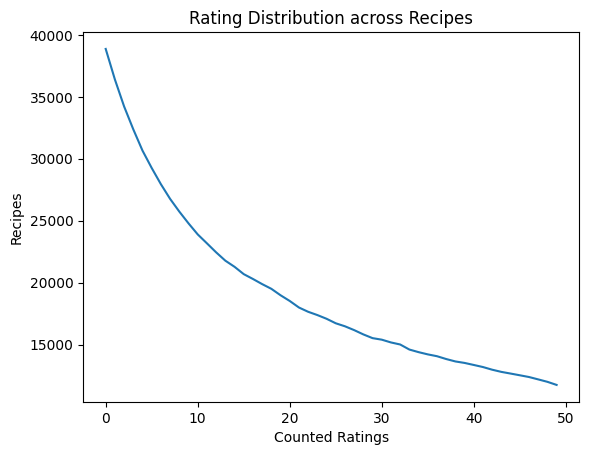

In [65]:
plt.plot(count_ratings)

# Add title and labels
plt.title("Rating Distribution across Recipes")  # Add title
plt.xlabel("Counted Ratings")         # Add x-axis label
plt.ylabel("Recipes")         # Add y-axis label

# Display the plot
plt.show()

It seems like more than 10 times rated recipes are the crucial points so we will look at only these in our model.

In [8]:
recipe_group = glutenfree.groupby("RecipeId").filter(lambda x: x["RecipeId"].count() > 10)


##### Users

Now we need to decide which recipes we want to include. Meaning we will check the number of ratings it has. Therefore, lets look at the following plot.

In [67]:
count_user_ratings = []
for i in range(1, 51):
    count_user_ratings.append(glutenfree.groupby("AuthorId").filter(lambda x: x["AuthorId"].count() > i).shape[0])

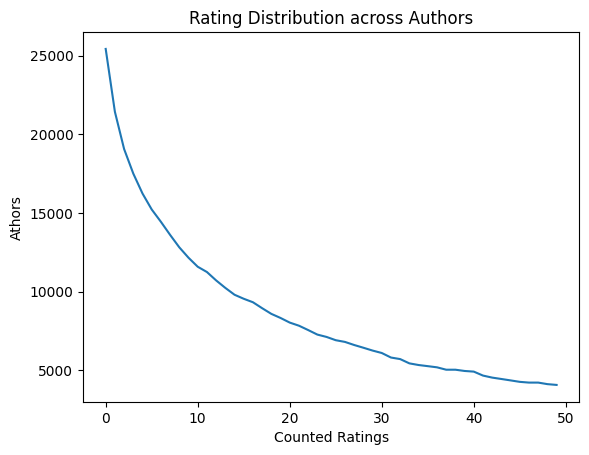

In [68]:
plt.plot(count_user_ratings)

# Add title and labels
plt.title("Rating Distribution across Authors")  # Add title
plt.xlabel("Counted Ratings")         # Add x-axis label
plt.ylabel("Athors")         # Add y-axis label

# Display the plot
plt.show()

It seems like users that rated more than 5 recipes are speakable of. So we will consider these in our model.

In [9]:
user_rating_group = glutenfree.groupby(['AuthorId']).filter(lambda x: x["AuthorId"].count() > 5)


In [10]:
glutenfree = glutenfree[glutenfree['AuthorId'].isin(user_rating_group['AuthorId'])]
glutenfree = glutenfree[glutenfree['RecipeId'].isin(recipe_group['RecipeId'])]

#glutenfree = glutenfree[glutenfree['RecipeId'].isin(recipe_group.index)]


In [11]:
glutenfree.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7960 entries, 21 to 1401742
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   RecipeId  7960 non-null   int64
 1   AuthorId  7960 non-null   int64
 2   Rating    7960 non-null   int64
dtypes: int64(3)
memory usage: 248.8 KB


Check if a specific dish is in the glutenfree df.

In [12]:
recipe_id = 76
is_in_glutenfree = recipe_id in glutenfree.index
print(is_in_glutenfree)

False


---

### Create a new user taste profile: Glutenfree and fish lover

Now that we have our glutenfree dataframe. We will feed our dataframe with new recipes to create a profile of our persona. 

Our persona likes fish and doesn't eat gluten. The upcoming dishes were selected manually on food.com. You have to imagine you ate these meals and then rated them with the highest rating (=5).

User ID = 29600

In [13]:
new_row = {'RecipeId': 41992, 'AuthorId': 29600, 'Rating': 6}

glutenfree.loc[len(glutenfree)] = new_row
print(glutenfree.tail(1))

      RecipeId  AuthorId  Rating
7960     41992     29600       6


In [14]:
new_row_1 = {'RecipeId': 44487, 'AuthorId': 29600, 'Rating': 6}

glutenfree.loc[len(glutenfree)] = new_row_1
print((glutenfree).tail(2))

      RecipeId  AuthorId  Rating
7960     41992     29600       6
7961     44487     29600       6


In [15]:
new_row_2 = {'RecipeId': 339474, 'AuthorId': 29600, 'Rating': 6}

glutenfree.loc[len(glutenfree)] = new_row_2
print((glutenfree).tail(2))

      RecipeId  AuthorId  Rating
7961     44487     29600       6
7962    339474     29600       6


In [16]:
new_row_3 = {'RecipeId': 255600, 'AuthorId': 29600, 'Rating': 6}

glutenfree.loc[len(glutenfree)] = new_row_3
print((glutenfree).tail(2))

      RecipeId  AuthorId  Rating
7962    339474     29600       6
7963    255600     29600       6


In [17]:
new_row_4 = {'RecipeId': 37457, 'AuthorId': 29600, 'Rating': 6}

glutenfree.loc[len(glutenfree)] = new_row_4
print((glutenfree).tail(2))

      RecipeId  AuthorId  Rating
7963    255600     29600       6
7964     37457     29600       6


In [18]:
new_row_5 = {'RecipeId': 41992, 'AuthorId': 29600, 'Rating': 6}

glutenfree.loc[len(glutenfree)] = new_row_5
print((glutenfree).tail(2))

      RecipeId  AuthorId  Rating
7964     37457     29600       6
7965     41992     29600       6


In [19]:
new_row_6 = {'RecipeId': 57170, 'AuthorId': 29600, 'Rating': 6}

glutenfree.loc[len(glutenfree)] = new_row_6
print((glutenfree).tail(2))

      RecipeId  AuthorId  Rating
7965     41992     29600       6
7966     57170     29600       6


In [20]:
new_row_7 = {'RecipeId': 48824, 'AuthorId': 29600, 'Rating': 6}

glutenfree.loc[len(glutenfree)] = new_row_7
print((glutenfree).tail(2))

      RecipeId  AuthorId  Rating
7966     57170     29600       6
7967     48824     29600       6


In [21]:
new_row_8 = {'RecipeId': 88346, 'AuthorId': 29600, 'Rating': 6}

glutenfree.loc[len(glutenfree)] = new_row_8
print((glutenfree).tail(2))

      RecipeId  AuthorId  Rating
7967     48824     29600       6
7968     88346     29600       6


In [22]:
new_row_9 = {'RecipeId': 138183, 'AuthorId': 29600, 'Rating': 6}

glutenfree.loc[len(glutenfree)] = new_row_9
print((glutenfree).tail(2))

      RecipeId  AuthorId  Rating
7968     88346     29600       6
7969    138183     29600       6


In [23]:
new_row_10 = {'RecipeId': 109163, 'AuthorId': 29600, 'Rating': 6}

glutenfree.loc[len(glutenfree)] = new_row_10
print((glutenfree).tail(2))

      RecipeId  AuthorId  Rating
7969    138183     29600       6
7970    109163     29600       6


In [24]:
new_row_11 = {'RecipeId': 305221, 'AuthorId': 29600, 'Rating': 6}

glutenfree.loc[len(glutenfree)] = new_row_11
print((glutenfree).tail(2))

      RecipeId  AuthorId  Rating
7970    109163     29600       6
7971    305221     29600       6


In [25]:
glutenfree.head()

,RecipeId,AuthorId,Rating
21,780,2312,6
551,8806,7802,1
1350,10757,15572,6
1811,1505,13483,5
1989,11427,4470,1


---

### Modeling

#### 1. KNN

In [26]:
glutenfree = glutenfree.pivot_table(index='RecipeId', columns='AuthorId', values='Rating')

# Replace NaN with 0
glutenfree.fillna(0, inplace=True)

In [37]:
# Define AuthorId
specific_author_id = 29600

# Extract Ratings for specific AuthorId
query_data = glutenfree.loc[:, specific_author_id].values.reshape(1, -1)

# Initialize and fit the Nearest Neighbors model
# Überprüfen Sie, ob die Anzahl der Nachbarn größer ist als die Anzahl der Zeilen im DataFrame
n_neighbors = min(600, glutenfree.shape[0])
knn_model = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=n_neighbors)
knn_model.fit(glutenfree.T)  # Transpose the DataFrame to obtain the correct shape

# Find the indices of the nearest neighbors for the specific AuthorId
distances, neighbor_indices = knn_model.kneighbors(query_data)

# Überprüfen Sie, ob der berechnete Indexwert innerhalb des gültigen Bereichs liegt
valid_indices = [idx for idx in neighbor_indices.flatten() if idx < glutenfree.shape[0]]

# Output the RecipeIds of the nearest neighbors
nearest_recipe_ids = glutenfree.index[valid_indices]

# Retrieve the corresponding names for the RecipeIds
nearest_recipe_names = df_recipes[df_recipes['RecipeId'].isin(nearest_recipe_ids)]['Name'].values

# Create a DataFrame with the RecipeIds and their names
nearest_recipes_df = pd.DataFrame({'RecipeId': nearest_recipe_ids, 'Name': nearest_recipe_names})

#create dataframe for streamlit
nearest_recipe_ids_df = pd.DataFrame({'RecipeId': nearest_recipe_ids})

# Sort the DataFrame by the smallest distance
# nearest_recipes_df_sorted = nearest_recipes_df.sort_values(by='RecipeId')

# Give RecipeIds & Names
print("RecipeIds and their names with the smallest distance for AuthorId", specific_author_id, "are:")
print(nearest_recipes_df)

RecipeIds and their names with the smallest distance for AuthorId 29600 are:
     RecipeId                                               Name
0       14953                 Black Bean, Corn, and Tomato Salad
1      160607                         Italian Salad Dressing Mix
2       94781                                       Dill Pickles
3       34087                          Oven Fried Sweet Potatoes
4      153163                   Holiday Flourless Chocolate Cake
..        ...                                                ...
339    439793  Feta, Sweet Potato and Spinach Crustless Quich...
340     38478  Buttery Garlic and Sharp Cheddar Biscuits - Lo...
341    446595               Famous Peanut Butter Oatmeal Cookies
342    369025         2 Ingredients (Eggs &amp; Banana) Pancakes
343     38080                                     Eggs in Clouds

[344 rows x 2 columns]


---
Uncommend to download for streamlit:

In [38]:
# CSV of recommendations for streamlit
# nearest_recipe_ids_df.to_csv("../data/knn_glutenfree_glutenfreefish.csv")

---

In [39]:
# Nehmen wir an, Ihre spezifische AuthorId ist 'specific_author_id'
specific_author_id = 29600  # Hier die spezifische AuthorId eintragen

# Filterung des DataFrames df_reviews basierend auf den Bedingungen
reviews_of_specific_author = df_reviews[
    (df_reviews['AuthorId'] == specific_author_id) &  # Nur Bewertungen der spezifischen AuthorId
    (df_reviews['RecipeId'].isin(nearest_recipe_ids))  # Nur Bewertungen von RecipeIds in nearest_recipe_ids
]

# Auswahl der Spalten "RecipeId" und "Rating" aus dem DataFrame
rated_recipes = reviews_of_specific_author[['RecipeId', 'Rating']]

# Ausgabe der bewerteten RecipeIds und ihrer Bewertungen
print(rated_recipes)



Empty DataFrame
Columns: [RecipeId, Rating]
Index: []


#### 2. NMF


In [30]:
model = NMF(n_components=6)
model.fit(glutenfree)

NMF(n_components=6)

In [31]:
H = pd.DataFrame(model.components_)    
W = pd.DataFrame(model.transform(glutenfree))    

# Create new df with dot product of W & H
V = pd.DataFrame(np.dot(W, H), columns=glutenfree.columns)
V.index = glutenfree.index

V.tail()

AuthorId,1533,1535,2310,2312,4291,4439,4470,5060,6258,6357,...,1929066,2123645,2324285,2549237,2597942,2613820,1802849661,2000225933,2000431901,2001112113
RecipeId,,,,,,,,,,,,,,,,,,,,,
463710,0.000177,0.005981,0.006360,0.011473,0.000667,0.021210,0.025421,0.008076,0.020138,0.007452,...,6.181149e-03,1.601931e-01,0.006228,0.076531,0.040187,0.004816,0.019616,0.005958,0.003080,0.004362
467871,0.002439,0.012038,0.003640,0.002070,0.000000,0.000453,0.029692,0.021992,0.010469,0.014520,...,6.648393e-07,7.600100e-03,0.009024,0.005015,0.000723,0.000817,0.003965,0.000154,0.001906,0.008246
490362,0.000000,0.000495,0.000000,0.000000,0.000000,0.000000,0.000000,0.001102,0.000000,0.000995,...,6.884693e-04,0.000000e+00,0.000820,0.001008,0.004228,0.000269,0.002236,0.000476,0.000301,0.000159
501408,0.000576,0.002847,0.000799,0.000312,0.000015,0.000000,0.007015,0.005275,0.002476,0.003506,...,4.976841e-05,1.457480e-07,0.002191,0.000086,0.000305,0.000167,0.001061,0.000034,0.000458,0.001903
513062,0.003883,0.018923,0.005380,0.002103,0.000000,0.000000,0.047273,0.035014,0.016668,0.023118,...,1.058504e-06,0.000000e+00,0.014367,0.000000,0.000000,0.000990,0.006066,0.000000,0.002936,0.012739


In [32]:
V.columns.unique()

Index([      1533,       1535,       2310,       2312,       4291,       4439,
             4470,       5060,       6258,       6357,
       ...
          1929066,    2123645,    2324285,    2549237,    2597942,    2613820,
       1802849661, 2000225933, 2000431901, 2001112113],
      dtype='int64', name='AuthorId', length=989)

In [45]:
top_indices = V[29600].nlargest(1000000000000000).index.tolist()

# Ausgabe der Indizes
print(top_indices)

[15580, 305221, 370103, 135116, 350531, 166030, 150759, 128956, 149748, 304683, 415600, 242482, 367498, 418122, 149207, 123403, 219724, 417103, 34382, 244193, 305558, 343934, 141988, 329560, 253308, 304187, 181195, 244738, 414808, 347911, 226251, 94356, 455974, 344049, 242475, 307468, 330186, 350836, 230695, 450939, 460402, 321213, 363588, 8701, 198732, 420398, 50124, 150137, 304302, 384909, 27652, 287183, 191796, 135124, 322701, 145705, 294506, 232083, 362340, 387336, 171094, 69253, 239859, 377030, 34059, 237022, 52285, 224691, 439793, 95068, 370046, 54017, 300298, 396953, 173525, 310488, 364732, 14680, 263512, 41463, 139955, 5408, 38766, 235630, 59336, 364590, 186849, 229531, 272813, 24917, 106627, 347339, 145678, 201473, 421575, 23528, 24088, 342174, 71129, 8650, 28603, 1505, 255918, 443414, 369025, 316624, 74760, 21202, 208437, 2642, 95376, 69240, 37535, 51861, 242328, 69271, 261724, 11217, 417779, 164652, 56836, 11427, 140868, 220989, 359178, 141053, 162765, 127255, 26932, 278729,

In [46]:
# DataFrame df_recomm mit einer Spalte "RecipeId" erstellen
df_recomm = pd.DataFrame({'RecipeId': top_indices})

# Ausgabe des neuen DataFrames
print(df_recomm)

     RecipeId
0       15580
1      305221
2      370103
3      135116
4      350531
..        ...
727    293500
728    397737
729     69370
730      2930
731    124172

[732 rows x 1 columns]


---
Uncommend to download for streamlit:

In [47]:
# CSV of recommendations for streamlit
# df_recomm.to_csv("../data/nmf_glutenfree_glutenfreefish.csv")

---

In [48]:
# Merge der DataFrames basierend auf der Spalte "RecipeId"
df_recomm = df_recomm.merge(df_recipes[['RecipeId', 'Name']], on='RecipeId', how='left')

# Umbenennen der Spalte "Name" in "RecipeName"
df_recomm = df_recomm.rename(columns={'Name': 'RecipeName'})

# Ausgabe des neuen DataFrames
print(df_recomm)

     RecipeId                                      RecipeName
0       15580                        Grilled Moroccan Chicken
1      305221                   Lemon Pepper Fish Greek Style
2      370103                        Saut&eacute;ed Mushrooms
3      135116                         Potatoes a L'alsacienne
4      350531                             Homemade Oven Chips
..        ...                                             ...
727    293500       South Beach Diet P1 Peanut Butter Muffins
728    397737                        Habanero Mango Hot Sauce
729     69370  Grilled Peaches with Whipped Cream and Caramel
730      2930                          Winnipeg Chicken Curry
731    124172                      The World's Best Fruitcake

[732 rows x 2 columns]


Now lets check if the user has already rated one of the recommended recipes. Since we only want to suggest the not rated recipes yet.

In [36]:
# AuthorId is 'specific_author_id'
specific_author_id = 29600

# Filter the dataframes df_reviews based on the conditions
reviews_of_specific_author = df_reviews[
    (df_reviews['AuthorId'] == specific_author_id) &
    (df_reviews['RecipeId'].isin(df_recomm)) 
]

# select the recipeIds and their rating
rated_recipes = reviews_of_specific_author[['RecipeId', 'Rating']]
print(rated_recipes)


Empty DataFrame
Columns: [RecipeId, Rating]
Index: []


None of the recommended recipes where rated so here we have our recommended recipes according to the NMF Model.